## Makemore Pt 2

This notebook implements a MLP character model to predict the next character given more characters of context

The first model implemented in makemore.ipynb only considered the previous character for context and learned to predict it. This next model based on the paper by _Bengio et al_.

1. associate with each character in the vocabulary a distributed character feature vector (a real valued vector in Rm),
2. express the joint probability function of character sequences in terms of the feature vectors
of these characters in the sequence, and
3. learn simultaneously the character feature vectors and the parameters of that probability
function.

In [1]:
from collections import deque
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt


words = open('names.txt').read().splitlines()

In [2]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

## Architecture Overview

- Inputs: N Characters * E dimensions feature vectors

E.g. if using 3 context chars and encoding each as a vector in 3 dimensional space, then each input to the NN is a 9 dimensional vector.

- Layers:

1) Embedding lookup : takes in each of N characters,outputs a feature vector for each.
2) Hidden layer 1 + tanh activation
3) Output layer 2 + softmax activation

Output:

Probability distribution of the next character given those feature vectors

In [3]:
# Utility dicts
stoi = {c:i+1 for i,c in enumerate(sorted(set("".join(words))))}
stoi["."] = 0
itos = {i:c for c,i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [4]:
# Create the dataset
CONTEXT_WINDOW = 3
def build_dataset(wds):
    X,Y = [],[]
    for w in wds:
        window = deque([0]*CONTEXT_WINDOW,maxlen=CONTEXT_WINDOW)
        for c in w + ".":
            ix = stoi[c]
            X.append(list(window))
            Y.append(ix)
            # print(''.join(itos[i] for i in window), '--->', itos[ix])
            window.append(ix)
    X = torch.tensor(X)
    Y = torch.tensor(Y)

    print(X.shape,Y.shape)
    return X,Y

random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])
Xtr[0,:]

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


tensor([0, 0, 0])

In [5]:
# Define the embedding mapping, takes in a in one hot encoding w 27 classes -> outputs vector in Rn
N = 10
C = torch.randn((27,N))

To get the embeddings we just index C with our

In [6]:
Xtr

tensor([[ 0,  0,  0],
        [ 0,  0, 25],
        [ 0, 25, 21],
        ...,
        [15, 12,  4],
        [12,  4,  1],
        [ 4,  1, 14]])

In [7]:
emb = C[Xtr]
emb.shape

torch.Size([182625, 3, 10])

### Hidden layer 1

In [8]:
# Multiple ways to make the inputs 2d
# torch.cat([emb[:, 0, :],emb[:, 1, :], emb[:, 2, :]],dim=1)
# torch.cat(torch.unbind(emb,dim = 1), dim=1)
emb.view(-1,N*3)


tensor([[-1.5676,  1.0824,  2.5399,  ..., -0.1263, -0.9873, -0.8441],
        [-1.5676,  1.0824,  2.5399,  ..., -2.3574, -0.0587,  0.8110],
        [-1.5676,  1.0824,  2.5399,  ..., -0.7867, -0.6942, -0.9545],
        ...,
        [-0.2487,  0.2483, -2.3215,  ...,  0.1274,  1.2345, -0.9938],
        [ 1.4437,  0.9874,  0.6846,  ...,  0.7054,  1.2636, -0.1788],
        [ 0.1627,  0.4557, -0.5982,  ...,  1.8971, -0.9777, -1.0260]])

In [9]:
W1 =  torch.randn((N*CONTEXT_WINDOW,300))
b1 = torch.randn(300)
(W1.shape,b1.shape)

(torch.Size([30, 300]), torch.Size([300]))

In [10]:
# Pass through 300 neuron hidden layer
h = torch.tanh(emb.view(-1,N*CONTEXT_WINDOW) @ W1 + b1)

In [11]:
h

tensor([[-0.3136,  0.9659,  1.0000,  ..., -0.9971, -1.0000,  1.0000],
        [ 1.0000,  0.9988,  1.0000,  ...,  0.9908, -1.0000,  1.0000],
        [-1.0000, -0.9984, -0.0916,  ..., -1.0000,  1.0000,  1.0000],
        ...,
        [-0.9178, -1.0000,  0.9989,  ..., -0.9985,  0.7806, -0.9873],
        [ 0.9672,  0.2968, -0.9662,  ...,  1.0000,  0.9776,  0.9993],
        [-0.9761,  1.0000, -0.9994,  ...,  0.7184,  0.9921, -1.0000]])

### Output layer

In [12]:
W2 = torch.randn((300,27))
b2 = torch.randn(27)

In [13]:
logits = h @ W2 + b2
# counts = logits.exp()
# prob = counts / counts.sum(1, keepdims=True)
# prob.shape

In [14]:
# loss = -prob[torch.arange(100), Ytr[:100]].log().mean()
# loss

In [15]:
# cross_entropy takes the unnormalized logits then works out the cross-entropy loss, we don't need to normalize ourselves, which is inefficient
F.cross_entropy(logits, Ytr)

tensor(34.6985)

In [16]:
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [17]:
# Num parameters
sum(p.nelement() for p in parameters)

17697

### Training loop

Training set: used to train
Dev/validation: used to train/tune hyperparameters
Test: used to test

Notes:

- If training dataset contains far fewer examples than the number of parameters, the model will overfit the training set and show very low loss, does not mean the model is good (it won't generalise)
- While we could iterate on full dataset (forward + backward), this is inefficient and not done in practice -> use random mini-batches of the data which makes the forward/backward pass far more efficient

In [18]:
# Generate learning rates to try
lre = torch.linspace(-3,0,1000)
lrs = 10**lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [19]:
losses = []
for i in range(1000):
    # Forward pass
    ix = torch.randint(0, Xtr.shape[0], (32,))
    #Only forward + backward the mini batch
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1,N*CONTEXT_WINDOW) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = lrs[i]
    for p in parameters:
        p.data -= p.grad * lr
    losses.append(loss.item())
    print(loss.item())



28.58847999572754
37.19462585449219
32.00468826293945
36.38492965698242
38.07505798339844
34.8139762878418
31.485841751098633
35.602779388427734
38.14543151855469
29.799617767333984
30.65586280822754
31.170202255249023
30.86812973022461
24.747217178344727
30.559511184692383
36.6664924621582
36.60548400878906
35.73533248901367
39.793704986572266
29.308731079101562
35.13445281982422
29.208635330200195
40.98709487915039
32.19017791748047
29.097843170166016
33.540645599365234
28.120264053344727
31.709308624267578
29.943859100341797
34.62790298461914
34.927589416503906
30.832059860229492
33.88114929199219
33.515323638916016
31.572612762451172
28.04717445373535
32.7918586730957
31.151668548583984
32.2749137878418
30.269071578979492
32.84706497192383
34.40433120727539
28.675607681274414
30.572877883911133
28.901309967041016
28.47269058227539
34.42706298828125
39.08676528930664
25.545988082885742
35.010929107666016
29.83515167236328
31.428524017333984
35.180389404296875
28.31960105895996
35.62

Finding the optimal learning rate (tuning)

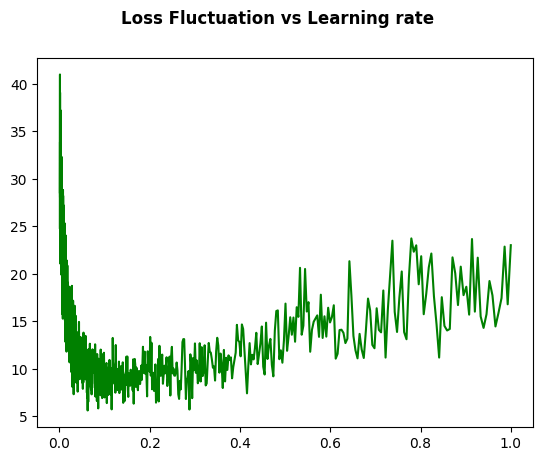

In [20]:
import matplotlib.pyplot as plt

plt.plot(lrs, losses, "g" )
plt.suptitle("Loss Fluctuation vs Learning rate", fontweight='bold')
plt.show()

From the graph we see the loss destabilizes with laearning rates >= to 0.15.

Thus we can infer suitable learning rates are around 0.1.

Best way to train is to start around 0.1 then learn the finer details with smaller lr around 0.01

In [21]:
losses = []
steps = []
for i in range(30000):
    # Forward pass
    ix = torch.randint(0, Xtr.shape[0], (64,))
    #Only forward + backward the mini batch
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1,N*CONTEXT_WINDOW) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = 0.01 if i < 10000 else 0.001
    for p in parameters:
        p.data -= p.grad * lr
    steps.append(i)
    losses.append(loss.item())
    print(loss.item())


20.366552352905273
16.465511322021484
23.497827529907227
22.042734146118164
17.127946853637695
21.237152099609375
19.167566299438477
17.147695541381836
21.966960906982422
17.679441452026367
18.4200439453125
20.083833694458008
16.353113174438477
16.759090423583984
18.161062240600586
20.77142906188965
19.006025314331055
16.159507751464844
15.926478385925293
16.823211669921875
17.085594177246094
14.804391860961914
16.58709144592285
14.296520233154297
13.65185260772705
18.529443740844727
14.609240531921387
17.64599609375
14.01227855682373
16.548187255859375
16.280471801757812
14.565829277038574
15.102534294128418
15.984461784362793
12.952506065368652
15.348323822021484
16.93349266052246
17.594179153442383
14.011751174926758
15.996927261352539
14.958463668823242
15.311985969543457
14.339214324951172
13.106596946716309
16.205596923828125
14.046971321105957
15.747105598449707
15.401927947998047
15.369317054748535
13.80024242401123
15.85668659210205
12.96678638458252
12.772279739379883
14.7185

after training on the training set we look at the train/dev set loss

In [47]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1,N*CONTEXT_WINDOW) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0021, grad_fn=<NllLossBackward0>)

In [48]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1,N*CONTEXT_WINDOW) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.0926, grad_fn=<NllLossBackward0>)

In [49]:
emb = C[Xte]
h = torch.tanh(emb.view(-1,N*CONTEXT_WINDOW) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.0937, grad_fn=<NllLossBackward0>)

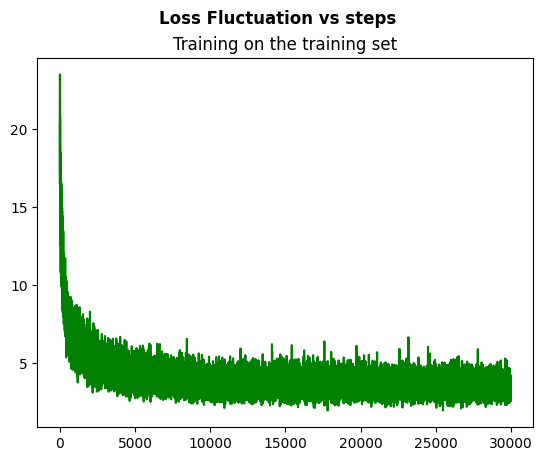

In [25]:
import matplotlib.pyplot as plt

plt.plot(steps, losses, "g" )
plt.suptitle("Loss Fluctuation vs steps", fontweight='bold')
plt.title("Training on the training set")
plt.show()

There seems to be a lot of thrashing with batch size 32-> we can try increasing batch size to reduce this

In [26]:
C

tensor([[-6.4219e+00,  2.2367e+00,  5.5311e+00, -4.0624e+00,  2.6979e+00,
          1.4505e-01, -1.2470e+00, -4.0861e-01, -2.7724e+00, -1.8634e+00],
        [ 1.9716e+00,  3.4969e+00, -8.8235e-01,  3.8666e+00, -3.5926e-02,
         -1.0863e+00,  1.9604e+00, -2.2683e+00,  1.2640e+00, -3.0391e+00],
        [ 1.0091e+00,  2.4871e-01, -1.1068e+00, -4.8494e-01,  6.8500e-01,
          8.2495e-01, -4.3513e-01, -3.7030e-01, -6.0103e-01, -9.1714e-01],
        [ 8.2801e-01,  2.5959e+00,  1.4675e+00, -1.1770e+00,  1.2940e+00,
         -5.9291e-01, -9.5804e-01, -1.6558e+00, -5.8190e-01,  1.2266e-01],
        [ 1.5816e+00,  1.7934e+00,  9.1570e-01, -4.1574e-01,  1.8472e+00,
          6.2967e-01,  1.0531e+00,  6.0935e-01, -1.6261e-01,  1.4078e+00],
        [-3.0840e+00,  1.6224e+00, -3.2851e+00, -2.1466e+00, -3.0802e+00,
         -5.0462e+00,  2.0758e+00,  2.5186e+00,  5.4798e-01,  1.6369e-01],
        [ 1.8673e+00,  7.6320e-02,  9.3294e-01, -2.2286e-01,  1.5036e-01,
          1.3390e+00, -4.2391e-0

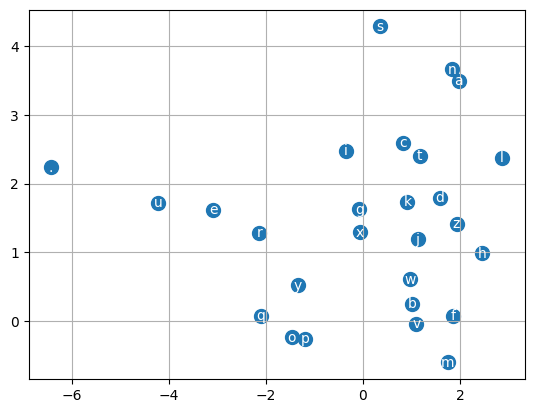

In [27]:
plt.scatter(C[:,0].data,C[:,1].data, s=100)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [28]:
for _ in range(100):

    out = []
    context = [0] * CONTEXT_WINDOW
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

kaydi.
zarerelladvum.
cayven.
chaynn.
emor.
lille.
adeleamiyah.
vila.
lelia.
athaiseylan.
bari.
mirmi.
irishecen.
monie.
tapkier.
jarriz.
dazylea.
avan.
aleigh.
rosee.
ddzingleetalee.
sarcak.
aarione.
kaysa.
lashle.
hso.
miyah.
wawi.
piac.
keliyah.
javiua.
soly.
kee.
non.
thyie.
evameeny.
loru.
ailahelin.
jaihi.
anyn.
scaula.
alyn.
bre.
janmaedycula.
shiyah.
lova.
gaheela.
aniane.
alynn.
shandrylen.
den.
fran.
emilie.
eva.
wabiella.
skybinarsh.
nyukon.
cagra.
milla.
ryhicharos.
ayah.
aryak.
eulone.
atiann.
ditay.
maheli.
phun.
adalaniah.
bawier.
maleem.
mish.
kohli.
amey.
syn.
jer.
shrah.
gacillyn.
kine.
sante.
lau.
sharni.
miah.
abamin.
pevzorah.
jilasnixeysilanika.
baree.
murenaas.
theric.
pbrerenaka.
khali.
lola.
talin.
masie.
nelyrikerione.
jose.
ale.
shell.
kah.
soy.
leon.


With the current network configuration, can achieve  loss of 2.2055 on the test set. It seems with the 18000ish parameters and enough steps, we begin to overfit on the training set as the train losses drift away from the test losses.

In actual production, lots of experiments would be ran to find best dev set performance. Then once we find the best hyperparameters, we run on test set once.

# Evaluation of Network

1) Awful initialisation

Extreme values of the logits results in extremely high loss as opposed to initialising with a roughly uniform distribution. This leads to hockey stick like loss trajectory.

Improves loss as more time spent actually optimising from reasonable initial loss.

2) Saturated tanh

A  big issue in the current network is that the tanh activation values are highly saturated on initialisation, this means that they cannot backpropagate any gradient because the local gradient is always 0.

This results in dead neurons and strongly limits the ability of the network to learn.

This is a large problem, If a neuron is not activated in the active region of tanh for any training examples, it will remain stuck and not learn.

In [42]:
N = 10
C = torch.randn((27,N))
emb = C[Xtr]
W1 = torch.randn((N*CONTEXT_WINDOW,300)) / ((N*CONTEXT_WINDOW) ** 0.5)
b1 = torch.randn(300) * 0.01
preact = emb.view(-1,N*CONTEXT_WINDOW) @ W1 + b1

print(f"Preact Mean: {preact.mean().item():.4f} (Should be ~0)")
print(f"Preact Std:  {preact.std().item():.4f} (Should be ~1.67)")

h = torch.tanh(preact)
W2 = torch.randn((300,27)) / (300**0.5)
b2 = torch.randn(27) * 0

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

Preact Mean: 0.0030 (Should be ~0)
Preact Std:  0.9725 (Should be ~1.67)


(array([334., 258., 262., 264., 237., 239., 250., 186., 187., 198., 181.,
        181., 192., 176., 164., 177., 203., 145., 150., 196., 184., 152.,
        143., 154., 158., 186., 153., 154., 139., 149., 142., 168., 168.,
        173., 175., 183., 155., 204., 188., 224., 170., 190., 207., 225.,
        276., 238., 245., 266., 314., 337.]),
 array([-9.99252498e-01, -9.59286212e-01, -9.19319925e-01, -8.79353639e-01,
        -8.39387352e-01, -7.99421066e-01, -7.59454780e-01, -7.19488493e-01,
        -6.79522207e-01, -6.39555920e-01, -5.99589634e-01, -5.59623348e-01,
        -5.19657061e-01, -4.79690775e-01, -4.39724488e-01, -3.99758202e-01,
        -3.59791915e-01, -3.19825629e-01, -2.79859343e-01, -2.39893056e-01,
        -1.99926770e-01, -1.59960483e-01, -1.19994197e-01, -8.00279105e-02,
        -4.00616241e-02, -9.53376293e-05,  3.98709488e-02,  7.98372352e-02,
         1.19803522e-01,  1.59769808e-01,  1.99736094e-01,  2.39702381e-01,
         2.79668667e-01,  3.19634954e-01,  3.59601

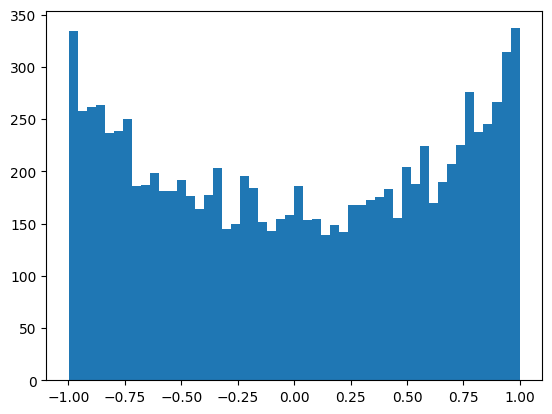

In [43]:
plt.hist(h.view(-1).tolist()[:10000],bins = 50)

In [46]:
import bisect
milestones = [50000, 75000, 100000]
values = [0.1, 0.05, 0.03,0.01]
losses = []
steps = []
for i in range(200000):
    # Forward pass
    ix = torch.randint(0, Xtr.shape[0], (64,))
    #Only forward + backward the mini batch
    emb = C[Xtr[ix]]
    preact = emb.view(-1,N*CONTEXT_WINDOW) @ W1 + b1
    h = torch.tanh(preact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = values[bisect.bisect_right(milestones, i)]
    for p in parameters:
        p.data -= p.grad * lr
    steps.append(i)
    losses.append(loss.item())
    if i % 1000 == 0:
        print(loss.item())


3.4428250789642334
2.5930075645446777
2.0965473651885986
2.38217830657959
2.390406608581543
2.6188857555389404
2.130181312561035
2.214582920074463
2.267277717590332
2.407745599746704
2.11942458152771
2.155163049697876
2.365837335586548
2.113288640975952
2.317307472229004
2.2990448474884033
2.3248093128204346
1.9918413162231445
2.369326591491699
1.8748501539230347
2.173496961593628
2.0808498859405518
2.2271969318389893
2.3860435485839844
1.7608081102371216
1.9540506601333618
1.9597524404525757
2.084193468093872
2.2194063663482666
2.2637336254119873
2.1987133026123047
2.0736937522888184
2.245283365249634
2.0345001220703125
2.0914909839630127
2.1220107078552246
1.9343258142471313
2.040079116821289
2.1493778228759766
2.0158939361572266
2.054643154144287
2.1827402114868164
1.9973291158676147
2.06782603263855
1.964003324508667
1.8855772018432617
2.028773069381714
2.128162145614624
2.1858420372009277
2.064342975616455
2.080540895462036
2.146415948867798
1.9838956594467163
2.1844282150268555
2

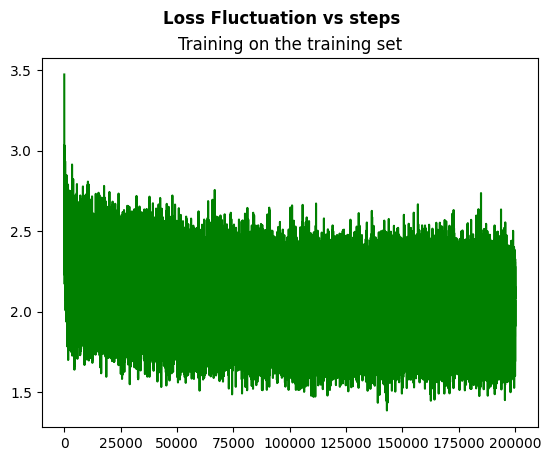

In [32]:
plt.plot(steps, losses, "g" )
plt.suptitle("Loss Fluctuation vs steps", fontweight='bold')
plt.title("Training on the training set")
plt.show()

(array([2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 1.000e+00,
        0.000e+00, 2.000e+00, 2.000e+00, 6.000e+00, 4.000e+00, 1.000e+01,
        7.000e+00, 1.200e+01, 4.000e+00, 1.600e+01, 1.700e+01, 2.700e+01,
        3.200e+01, 3.100e+01, 4.400e+01, 4.800e+01, 6.300e+01, 6.000e+01,
        7.400e+01, 6.300e+01, 9.800e+01, 1.160e+02, 1.520e+02, 1.380e+02,
        1.830e+02, 1.750e+02, 2.410e+02, 3.090e+02, 3.420e+02, 3.350e+02,
        3.460e+02, 3.790e+02, 3.490e+02, 4.980e+02, 4.780e+02, 5.130e+02,
        6.400e+02, 5.890e+02, 7.120e+02, 9.190e+02, 9.450e+02, 9.340e+02,
        1.003e+03, 9.200e+02, 7.590e+02, 6.740e+02, 5.860e+02, 5.760e+02,
        4.370e+02, 4.200e+02, 4.470e+02, 3.290e+02, 3.480e+02, 3.050e+02,
        3.140e+02, 2.510e+02, 2.420e+02, 2.610e+02, 1.630e+02, 2.210e+02,
        1.530e+02, 1.650e+02, 1.220e+02, 9.400e+01, 9.800e+01, 5.800e+01,
        5.800e+01, 5.100e+01, 4.100e+01, 3.100e+01, 3.400e+01, 2.800e+01,
        2.100e+01, 1.800e+01, 1.000e+0

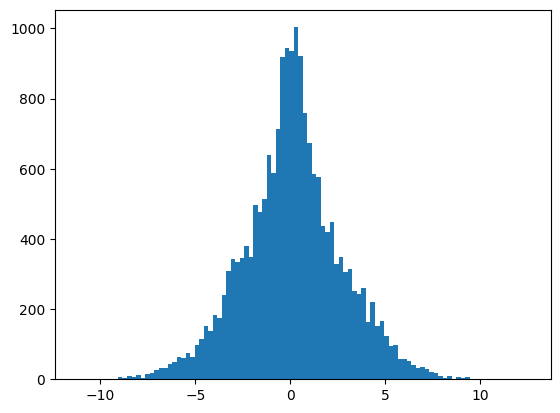

In [33]:
plt.hist(preact.view(-1).tolist(),bins = 100)

In [34]:
preact.view(-1).std()

tensor(2.6028, grad_fn=<StdBackward0>)

The preactivation values flowing through to the tanh are far too spread out, they have a large standard deviation meaning that a large proportion of values result in saturated tanh values.

We must scale down the parameters to restore the gaussian distribution of activations via squeezing the preactivations distribution.

Mathematically, each neuron is just a linear combination of wixi.
Therefore, each layer has variances that are fan_in times larger than the input distributions. Hence, following kaiming init, we have to scale down by dividing by root fan_in to retain constant variance/ std deviation

Since tanh squashes and decreases variance, we multiply by gain to counteract squashing effect


Normalize weights by square root of fan in * gain as per kaining init when training networks in practice.

In our case, with proper initialisation, performance improves to 2.0926 on test set over 150,000 cycles
